In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import nn

import matplotlib.pyplot as plt

from nn_functions import init_network_params, pack_params, layer_sizes
from nn_functions import update_rmsprop, update_sgd, update_adam
from nn_functions import get_batches, loss, batched_predict
from nn_functions import top_eigenvalue
from complex_nn import train_nn

In [7]:
params, log_train, grads_norm, hess_max, all_hidden_activations = train_nn(
    update_method='rmsprop',
    num_epochs=15,
    step_size=0.001,
    batch_size=32,
    plot=False,
    optimizer_params=None,
)

Epoch 0 — Loss: 1.0397e-01  |  ‖grad‖: 1.6221e+00  |  λ_max(H): 8.7081e+01
Epoch 1 — Loss: 8.0175e-02  |  ‖grad‖: 1.1276e+00  |  λ_max(H): 8.0664e+01
Epoch 2 — Loss: 6.3903e-02  |  ‖grad‖: 9.4996e-01  |  λ_max(H): 8.0059e+01
Epoch 3 — Loss: 5.7749e-02  |  ‖grad‖: 8.9021e-01  |  λ_max(H): 8.0569e+01
Epoch 4 — Loss: 5.2440e-02  |  ‖grad‖: 8.3332e-01  |  λ_max(H): 8.1211e+01
Epoch 5 — Loss: 4.9598e-02  |  ‖grad‖: 8.0422e-01  |  λ_max(H): 8.0374e+01
Epoch 6 — Loss: 4.9142e-02  |  ‖grad‖: 7.6349e-01  |  λ_max(H): 8.0140e+01
Epoch 7 — Loss: 4.5310e-02  |  ‖grad‖: 7.3559e-01  |  λ_max(H): 7.9482e+01
Epoch 8 — Loss: 4.4800e-02  |  ‖grad‖: 7.2374e-01  |  λ_max(H): 7.9014e+01
Epoch 9 — Loss: 4.9287e-02  |  ‖grad‖: 7.0073e-01  |  λ_max(H): 7.8796e+01
Epoch 10 — Loss: 4.3244e-02  |  ‖grad‖: 7.0588e-01  |  λ_max(H): 7.7867e+01
Epoch 11 — Loss: 4.0480e-02  |  ‖grad‖: 6.9103e-01  |  λ_max(H): 7.7437e+01
Epoch 12 — Loss: 3.9359e-02  |  ‖grad‖: 6.7795e-01  |  λ_max(H): 7.7514e+01
Epoch 13 — Loss: 3.874

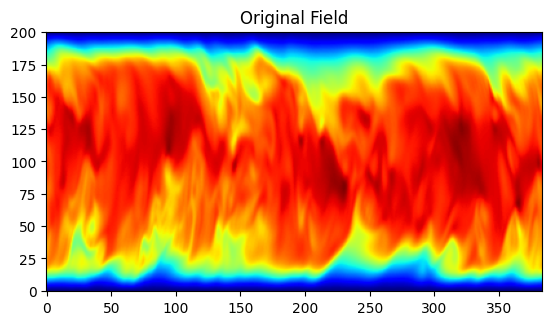

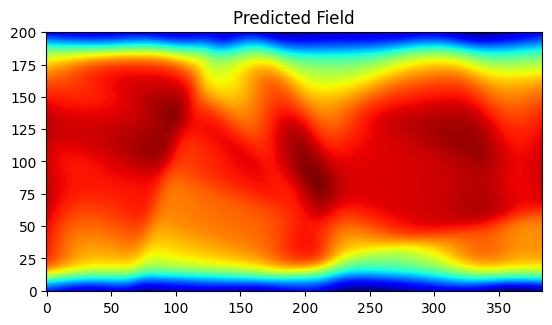

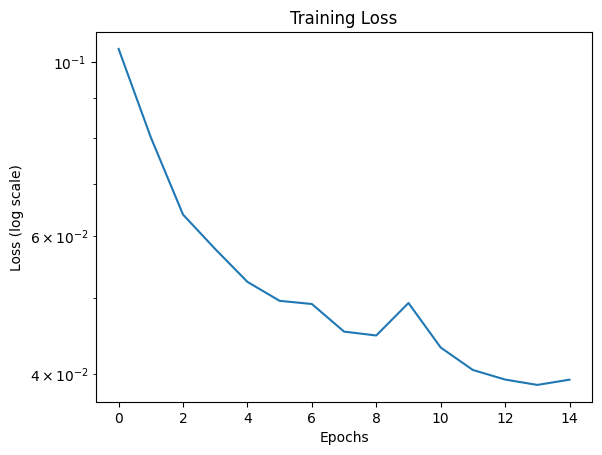

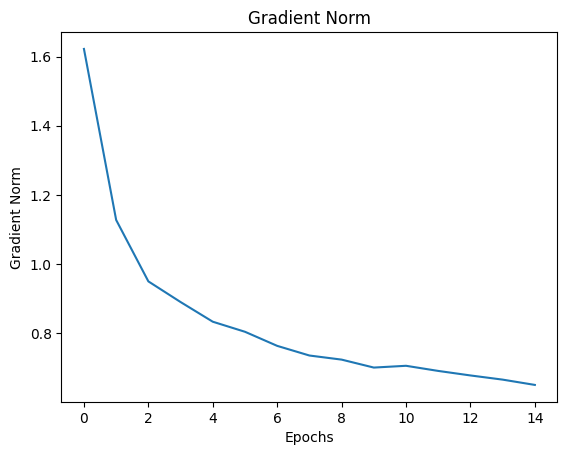

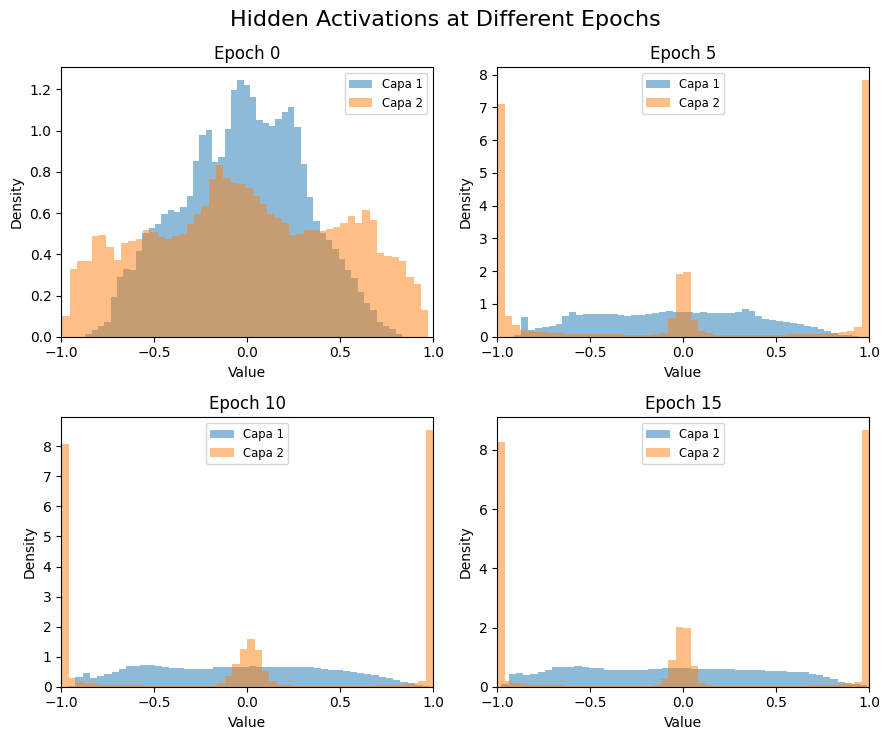

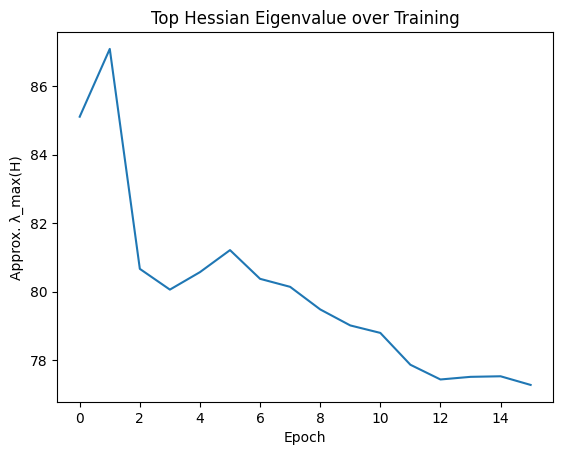

In [8]:
# Load data
field = jnp.load('field.npy')
field = field - field.mean()
field = field / field.std()
field = jnp.array(field, dtype=jnp.float32)
nx, ny = field.shape
xx = jnp.linspace(-1, 1, nx)
yy = jnp.linspace(-1, 1, ny)
xx, yy = jnp.meshgrid(xx, yy, indexing='ij')
xx = jnp.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
ff = field.reshape(-1, 1)

# Plot results
plt.figure()
plt.title('Original Field')
plt.imshow(ff.reshape((nx, ny)).T, origin='lower', cmap='jet')

plt.figure()
plt.title('Predicted Field')
plt.imshow(batched_predict(params, xx)[0].reshape((nx, ny)).T, origin='lower', cmap='jet')

# Plot loss function
plt.figure()
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.semilogy(log_train)

# Plot gradient norm
plt.figure()
plt.title('Gradient Norm')
plt.xlabel('Epochs')
plt.ylabel('Gradient Norm')
plt.plot(grads_norm)

# Especifica los epochs que quieres plotear
epochs_to_plot = [0, 5, 10, 15]
fig, axes = plt.subplots(2, 2, figsize=(12*.75, 10*.75), squeeze=False)
for ax, epoch in zip(axes.flatten(), epochs_to_plot):
    hidden_activations = all_hidden_activations[epoch]
    flat0 = hidden_activations[0].ravel()
    flat1 = hidden_activations[1].ravel()
    ax.hist(flat0, bins=50, alpha=0.5, density=True, label='Capa 1')
    ax.hist(flat1, bins=50, alpha=0.5, density=True, label='Capa 2')
    ax.set_title(f'Epoch {epoch}')
    ax.set_xlim(-1, 1)
    ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(fontsize='small')

plt.suptitle('Hidden Activations at Different Epochs', fontsize=16)
plt.tight_layout()

# --- plot how λ_max evolves ---
plt.figure()
plt.plot(hess_max)
plt.xlabel("Epoch")
plt.ylabel("Approx. λ_max(H)")
plt.title("Top Hessian Eigenvalue over Training")

# Show all plots
plt.show()